In [1]:
# Packages
############################
'''
Template for the 4th assignment
Student: Fabian Gobet
'''
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import math

import neptune
import random
import re
from nltk.tokenize.treebank import TreebankWordTokenizer
import statistics
import pickle
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split

In [2]:
# Classes
############################
# Vocabulary class
class Vocabulary:
    '''
    Class for dealing with our corpus
    '''

    def __init__(self, name, pairs):
        """
        Args:
            name (str): name of the language
            pairs (list): list of pairs of sentences
        """
        self.name = name
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.pairs = pairs
        for p1,p2 in pairs:
            self.add_sentence(p1)
            self.add_sentence(p2)


    def add_word(self, word):
        '''
        Add a word to the vocabulary
        :param word: a string
        '''
        # TODO: add the word to the vocabulary
        if not word in self.word2index:
            self.word2index[word] = len(self.word2index)
            self.index2word[len(self.index2word)] = word


    def add_sentence(self, sentence):
        '''
        Add a sentence to the vocabulary
        :param sentence: list of strings (words)
        '''
        # TODO add the sentence to the vocabulary, this method will call the add_word method
        for word in sentence:
            self.add_word(word)


# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, vocabulary, pairs):
        # TODO We want vocabulary and pairs to be attributes of the class
        self.vocabulary = vocabulary
        self.pairs = pairs

    def __len__(self):
        # TODO how many pairs do we have?
        return len(self.pairs)

    def __getitem__(self, ix):
        # TODO returns two tensors (question, answer) of the pair at index ix
        # TODO the tensors should be of type torch.tensor and should contain integers (word indices)
        q,a = self.pairs[ix]
        q = torch.tensor([self.vocabulary.word2index[word] for word in q])
        a = torch.tensor([self.vocabulary.word2index[word] for word in a])
        return q,a
        

class PositionalEncoding(nn.Module):
    '''
    Adapted from
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        try:
            assert x.size(0) < self.max_len
        except:
            print("The length of the sequence is bigger than the max_len of the positional encoding. Increase the max_len or provide a shorter sequence.")
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, pad_id=0, encoder_layers=6, decoder_layers=6, dim_feedforward=2048, num_heads=8, dropout_transformer=0.1, dropout_posenconding=0):
        super().__init__()

        # TODO add an embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model,padding_idx=pad_id)

        # TODO add a positional encoding layer
        self.pos_encoder = PositionalEncoding(d_model,dropout=dropout_posenconding) 

        # TODO add a transformer layer, you can use nn.Transformer. You can use the default values for the parameters, but what about batch_first?
        self.transformer = nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=encoder_layers, num_decoder_layers=decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout_transformer, batch_first=True)

        # TODO add a linear layer. Note: output should be probability distribution over the vocabulary
        self.linear = nn.Linear(d_model, vocab_size)

        # Stuff you may need
        self.vocab_size = vocab_size
        self.pad_id = pad_id
        self.num_heads = num_heads

    def create_padding_mask(self, x, pad_id=0):
        # TODO create a boolean mask for the <PAD> tokens
        return x.eq(pad_id)

    def forward(self, src, tgt):
        # S is the source sequence length, T is the target sequence length, N is the batch size, E is the feature number
        # src: (N, S)
        # tgt: (N, T)
        # src_pad_mask: (N, S)
        # tgt_pad_mask: (N, T)
        # mask the future : (N * num_heads, T, T)

        src_pad_mask = self.create_padding_mask(src, self.pad_id) # (N, S)
        tgt_pad_mask = self.create_padding_mask(tgt, self.pad_id) # (N, T)

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.pos_encoder(src)  # (N, S, E)
        tgt = self.pos_encoder(tgt) # (N, T, E)

        # Mask the memory
        memory_key_padding_mask = src_pad_mask  # (N, S)

        # Mask the future
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), dtype=torch.bool).to(tgt.device) # (T, T)
        
        # Expand to make it N * num_heads, T, T
        tgt_mask = tgt_mask.unsqueeze(0).repeat(tgt.size(0) * self.num_heads, 1, 1) # (N, T, T)
        # Transformer
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask,
                                  tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=memory_key_padding_mask) # (N, T, E)
        # Linear layer
        output = self.linear(output) # (N, T, V)
        return output

class EarlyStopper:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def check_early_stop(self, current_loss, model):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [3]:
# Methods
############################
def clear_punctuation(s):
    '''
    This function removes all the punctuation from a sentence and insert a blank between any letter and !?.
    :param s: a string
    :return: the "cleaned" string
    '''
    # Remove all the character that are not letters, puntuation or numbers
    s = re.sub(r"[^a-zA-Z.!?,']+", r" ", s)  
    # Insert a blank between any letter and !?. using regex
    #s = re.sub(r"([a-zA-Z])([!?.])", r"\1 \2", s)
    return s


def pickle_dump(obj, PATH, name):
    '''
    Save an object to a pickle file
    :param obj: object to save
    :param path: path to the pickle file
    '''
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH+name, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(PATH):
    '''
    Load an object from a pickle file
    :param path: path to the pickle file
    :return: the loaded object
    '''
    with open(PATH, 'rb') as f:
        obj = pickle.load(f)
    return obj

def print_random_elements(collection, k=5):
    '''
    Print k random elements from a collection
    :param collection: list of elements
    :param k: number of elements to print
    '''
    random_elements = random.sample(collection, k=k)
    for e in random_elements:
        print(e)

def collate_fn(batch,pad_idx):
  data, targets = zip(*batch)
  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=pad_idx)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=pad_idx)
  return padded_data, padded_targets

def checkpoint(model,optimizer,path='./MyFiles/',save_name=None):
  dic = {
      'model_state' : model.state_dict(),
      'optimizer' : optimizer.state_dict()
  }
  if save_name is not None:
    torch.save(dic, path+save_name+".pt")
  return dic

def load_checkpoint(path):
    checkpoint = torch.load(path)
    model_state = checkpoint['model_state']
    optimizer_state = checkpoint['optimizer']
    return model_state,optimizer_state

def create_pairs(path='./MyFiles',savename1="pairs2",savename2="pairs3",max_length=26,word_frequency_discard=10,verbose=True):
    '''
    Create pairs of sentences
    :return: a list of pairs of sentences
    '''
    

    if verbose:
        # Inspection of the data
        # Inspect movie_conversations.txt
        with open('./Data/movie_conversations.txt', 'r') as conv_file:
            for i in range(5):
                line = conv_file.readline()

        # Inspect movie_lines.txt
        with open('./Data/movie_lines.txt', 'r') as lines_file:
            for i in range(5):
                line = lines_file.readline()
    

    # Create pre-pairs of sentences
    ref_pairs = []
    with open('./Data/movie_conversations.txt', 'r') as conv_file:
        for line in conv_file:
            conversation = line.strip().split(' +++$+++ ')[-1][1:-1].replace("'", "").split(",")
            for i in range(len(conversation) - 1):
                ref_pairs.append((conversation[i].strip(), conversation[i+1].strip()))

    if verbose:
        # Print 5 random pairs
        print_random_elements(ref_pairs)

    # Generate a dictionary of lines with the following structure:
    # {line_id : line_text}
    # Filter out the empty lines and count them
    lines = {}
    empty_lines = 0

    with open('./Data/movie_lines.txt', 'r', encoding='cp1252') as line_file:
        for line in line_file:
            line = line.split(' +++$+++ ')
            tmpline = clear_punctuation(line[4].replace('\n','').replace("<u>","").replace("</u>","").lower()).strip()
            speech = re.sub('-+','',tmpline)
            if speech == '':
                empty_lines += 1
            else:
                speech = TreebankWordTokenizer().tokenize(speech)
                lines.update({line[0] : speech})

    if verbose:
        # Print number of empty lines
        print('Number of empty lines: {}'.format(empty_lines))

        # Print 5 random lines
        print_random_elements(list(lines.values()))

    # Tokenize the data
    chosen_refs = set()
    pairs = []

    for p in ref_pairs:
        if p[0] in lines and p[1] in lines:
            pairs.append([lines[p[0]]+['<EOS>'], ['<SOS>']+lines[p[1]]+['<EOS>']])
            chosen_refs.add(p[0])
            chosen_refs.add(p[1])

    if verbose:
        # Print 5 random pairs
        print_random_elements(pairs)

        # Filter out the sentences that are too long

        # Compute the length of each sentence
        # Compute the mean and standard deviation for sentence lengths
        sentence_lengths = [len(lines[r]) for r in chosen_refs]

        # Compute the mean and standard deviation
        mean_length = statistics.mean(sentence_lengths)
        std_dev = statistics.stdev(sentence_lengths)

        print('Mean sentence length: {}'.format(mean_length))
        print('Standard deviation: {}'.format(std_dev))
        print('Max sentence length: {}'.format(max(sentence_lengths)))
        print('Min sentence length: {}'.format(min(sentence_lengths)))

    # Create a list of pairs of sentences shorter tan max_length
    max_length = 26
    pairs2 = [p for p in pairs if len(p[0])<=max_length and len(p[1])<=max_length]

    if verbose:
        print('Len of pairs: {}'.format(len(pairs)))
        print('Len of pairs2: {}'.format(len(pairs2)))

        # Print 5 random pairs
        print_random_elements(pairs2)

    pickle_dump(pairs2,path,savename1+".pkl")


    # Filter out the words that are too rare
    # Compute the frequency of each word
    word_counts = {}
    num_words = 0

    for pair in pairs2:
        for sentence in pair:
            for word in sentence:
                if word not in word_counts:
                    word_counts[word] = 1
                else:
                    word_counts[word] += 1
                num_words += 1

    if verbose:    
        print('Number of words: {}'.format(num_words))
        print('Number of unique words: {}'.format(len(word_counts)))

        plt.plot(range(len(word_counts)), list(word_counts.values()))
        plt.xlabel('Word index')
        plt.ylabel('Word frequency')
        plt.suptitle('Word frequency distribution')
        plt.title('Frequency per word')
        plt.show()

        # Compute the mean and standard deviation for word counts
        mean_value = statistics.mean(word_counts.values())
        print("Mean value:", mean_value)
        print("Max value:", max(word_counts.values()))
        print("Min value:", min(word_counts.values()))

        # Plot the distribution of word counts < mean
        dict_lower_mean = {k: v for k, v in word_counts.items() if v < mean_value}
        sorted_dict_lower_mean = dict(sorted(dict_lower_mean.items(), key=lambda x: x[1], reverse=True))

        plt.plot(range(len(sorted_dict_lower_mean)), sorted_dict_lower_mean.values())
        plt.xlabel('Word index')
        plt.ylabel('Word count')
        plt.suptitle('Word count distribution')
        plt.title('Words with count < mean')
        plt.show()

    # Frequency threshold and filter out the words that are too rare
    freq_threshold = word_frequency_discard
    words_to_remove = [k for k, v in word_counts.items() if v < freq_threshold]
    pairs3 = [p for p in pairs2 if not any(word in words_to_remove for word in p[0]) and not any(word in words_to_remove for word in p[1])]

    if verbose:
        print('Len of pairs2: {}'.format(len(pairs2)))
        print('Len of pairs3: {}'.format(len(pairs3)))
        percentage_removed = (len(pairs2) - len(pairs3)) / len(pairs2) * 100
        print('Percentage of pairs removed: {:.2f}%'.format(percentage_removed))
        print('Number of words removed: {} - {:.2f}%'.format(len(words_to_remove),len(words_to_remove)/len(word_counts)*100))
    
    # Save the pairs to a pickle file
   

    pickle_dump(pairs3,path,savename2+".pkl")

    return pairs3

        

In [4]:
# Load pairs
############################
PATH = './MyFiles/'
#pairs = create_pairs(path=PATH,savename1="pre_pairs",savename2="pairs",max_length=26,word_frequency_discard=10,verbose=False)
pairs = pickle_load(PATH+'pairs.pkl')

In [25]:
# Pipeline parameters
############################

# Hyperparameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
batch_size = 32
rand_sample_num = 20000
learning_rate = 1e-3
d_model = 512
encoder_layers = 6
decoder_layers = 6
feed_forward_dim = 2048
nheads = 8
dropout_transformer = 0.3
dropout_posenconding = 0.2
patience = 3
epochs = 5


# Randomly sample pairs and splits
rand_sample_num = min(rand_sample_num,len(pairs))
rand_pairs = random.sample(pairs,rand_sample_num)
train_size = (int(0.8 * rand_sample_num)//batch_size)*batch_size
val_size = (rand_sample_num-train_size)//2
test_size = rand_sample_num-train_size-val_size
train_pairs, test_pairs, val_pairs = random_split(rand_pairs,[train_size,val_size,test_size])

# Vocabulary, Dataset and Dataloader
vocab = Vocabulary("English",rand_pairs)
train_dataset = Dataset(vocab,train_pairs)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))
val_dataset = Dataset(vocab,val_pairs)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))

In [26]:
# Pipeline initialization
############################

# Model, criterion, optimizer and scheduler
model = TransformerModel(vocab_size=len(vocab.word2index),d_model=d_model,pad_id=vocab.word2index["<PAD>"],
                         encoder_layers=encoder_layers,decoder_layers=decoder_layers,dim_feedforward=feed_forward_dim,
                         num_heads=nheads,dropout_transformer=dropout_transformer, dropout_posenconding=dropout_posenconding).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95, verbose=True)
stopper = EarlyStopper(patience=patience)


In [27]:
# Training
############################

train_losses, val_losses = [],[]

for epoch in range(epochs):
    model.train()
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data,targets[:,:-1])
        loss = criterion(output.view(-1,output.size(-1)),targets[:,1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        if i%100==0 or i==len(train_loader)-1:
            train_losses.append(loss.item())
            '''
            r_index = random.randint(0, len(data) - 1)
            r_target = targets[r_index].view(-1).cpu().detach().numpy()
            r_output = output[r_index].argmax(dim=-1).view(-1).cpu().detach().numpy()
            print("Target: ")
            print([vocab.index2word[i] for i in r_target])
            print("Output: ")
            print([vocab.index2word[i] for i in r_output])
            '''
            
            # Evaluation
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    output = model(data,targets[:,:-1])
                    loss = criterion(output.view(-1,output.size(-1)),targets[:,1:].contiguous().view(-1))
                    val_loss += loss.item()
                val_losses.append(val_loss/len(val_loader))
            print("Epoch: {}/{}, Batch: {}/{}:\n- Train Loss: {:.4f}".format(epoch+1,epochs,i,len(train_loader),train_losses[-1]))
            print("- Validation Loss: {:.4f}\n".format(val_losses[-1]))
            model.train()
                
    #lr_scheduler.step()
    if  stopper.check_early_stop(val_losses[-1], model):
        print("Early stopping")
        break

Epoch: 1/5, Batch: 0/500:
- Train Loss: 9.2931
- Validation Loss: 4.4586

Epoch: 1/5, Batch: 100/500:
- Train Loss: 2.9438
- Validation Loss: 3.1847

Epoch: 1/5, Batch: 200/500:
- Train Loss: 2.6987
- Validation Loss: 3.1070

Epoch: 1/5, Batch: 300/500:
- Train Loss: 2.8288
- Validation Loss: 3.1269

Epoch: 1/5, Batch: 400/500:
- Train Loss: 3.3627
- Validation Loss: 3.1264

Epoch: 1/5, Batch: 499/500:
- Train Loss: 2.9786
- Validation Loss: 3.0302

Epoch: 2/5, Batch: 0/500:
- Train Loss: 2.8056
- Validation Loss: 3.0280

Epoch: 2/5, Batch: 100/500:
- Train Loss: 3.1860
- Validation Loss: 3.0917

Epoch: 2/5, Batch: 200/500:
- Train Loss: 2.6754
- Validation Loss: 3.1234

Epoch: 2/5, Batch: 300/500:
- Train Loss: 2.9975
- Validation Loss: 3.1055

Epoch: 2/5, Batch: 400/500:
- Train Loss: 3.0189
- Validation Loss: 3.0844

Epoch: 2/5, Batch: 499/500:
- Train Loss: 3.0408
- Validation Loss: 3.1531

Epoch: 3/5, Batch: 0/500:
- Train Loss: 3.4474
- Validation Loss: 3.0849

Epoch: 3/5, Batch:

KeyboardInterrupt: 

In [9]:
print(stopper.best_loss)

1.4841938018798828


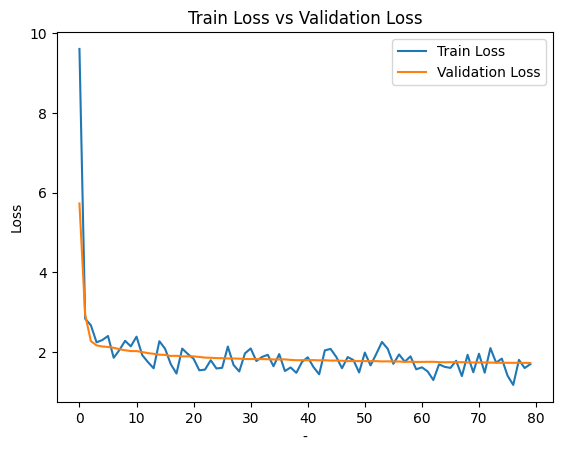

In [10]:
import matplotlib.pyplot as plt

# Plot train losses and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('-')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()


In [11]:
# Checkpointing
############################

PATH = './MyFiles/'
save_checkpoint = checkpoint(model,optimizer,path=PATH,save_name="checkpoint_dicts")
torch.save(model, PATH+'model.pt')
#model_state, optimizer_state = load_checkpoint(PATH+"checkpoint_dicts.pt")
pickle_dump(train_losses,PATH,"train_losses.pkl")
pickle_dump(val_losses,PATH,"val_losses.pkl")

#model = torch.load(PATH+'model.pt')
#train_losses = pickle_load(PATH+"train_losses.pkl")
#val_losses = pickle_load(PATH+"val_losses.pkl")

In [29]:
testing_loader = DataLoader(Dataset(vocab,test_pairs),batch_size=1,
                            shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))

test_sentence = "hello there."
test_sentence = TreebankWordTokenizer().tokenize(clear_punctuation(test_sentence.lower()))
data = torch.tensor([vocab.word2index[word] for word in test_sentence]+[vocab.word2index['<EOS>']]).unsqueeze(0)

target = torch.tensor([vocab.word2index["<SOS>"]]).unsqueeze(0)



with torch.no_grad():
    model.eval()
    data, _ = next(iter(testing_loader))
    data = data.to(device)
    target = torch.tensor([vocab.word2index["<SOS>"]]).unsqueeze(0).to(device)
    
    output_sentence = []
    for _ in range(20):  # Define max_output_length as per your requirement
        output = model(data, target)
        next_word_idx = output.argmax(dim=-1)[:,-1].unsqueeze(1)
        output_sentence.append(next_word_idx.item())
        target = torch.cat((target, next_word_idx), dim=1)

        if next_word_idx.item() == vocab.word2index["<EOS>"]:
            break

    print("Data:")
    print(" ".join([vocab.index2word[idx] for idx in data.view(-1).tolist()]))
    print("\nPredicted:")
    print(" ".join([vocab.index2word[idx] for idx in output_sentence]))

    

Data:
he did n't . <EOS>

Predicted:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
if __name__ == "__main__":
    # !!! Don't change the seed !!!
    torch.manual_seed(42)
    # !!!!!!

    # Download the data

    # SAVE and put the code above into a function that you will call if you need to generate something slightly different
    PATH = './MyFiles/'
    #pairs = create_pairs(path=PATH,savename1="pre_pairs",savename2="pairs",max_length=26,word_frequency_discard=10,verbose=False)
    pairs = pickle_load(PATH+'pairs.pkl')

    # Training loop (Consider writing a function for this/two separate functions for training and validation)

    # Evaluation by feeding the model with one input sentence at a time
